# Uber Fares Dataset - Initial Exploration 

## Description

The project is about on world's largest taxi company Uber inc. In this project, we're looking to predict the fare for their future transactional cases. Uber delivers service to lakhs of customers daily. Now it becomes really important to manage their data properly to come up with new business ideas to get best results. Eventually, it becomes really important to estimate the fare prices accurately.

https://www.kaggle.com/datasets/yasserh/uber-fares-dataset/

## Goals of the Project

- Understand the Dataset & cleanup.
- Build Regression models to predict the fare price of uber ride.
- Also evaluate the models & compare thier respective scores like R2, RMSE, etc.


## Objective

In this first notebook, we aim to understand the dataset and gain some insights about it. For that, we will verify the presence of missing data, the presence of outliers, and some feature distributions.

## Imports 

In [29]:
# basic libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  

from pandas.plotting import scatter_matrix

## Loading Data 

In [2]:
# loading raw data 
path_data = '../data/raw/'
uber_df = (
    pd.read_csv(path_data + 'uber.csv', index_col=[0])
    .reset_index(drop=True)
)

## Analyzing Data

This dataset contains the following columns:

- `key`: a unique identifier for each trip
- `fare_amount`: the cost of each trip in usd
- `pickup_datetime`: date and time when the meter was engaged
- `passenger_count`: the number of passengers in the vehicle (driver entered value)
- `pickup_longitude`: the longitude where the meter was engaged
- `pickup_latitude`: the latitude where the meter was engaged
- `dropoff_longitude`: the longitude where the meter was disengaged
- `dropoff_latitude`: the latitude where the meter was disengaged

In [3]:
# getting info about data 
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 12.2+ MB


The `fare_amount` feature will be our target. These are the values we want to predict. Features regarding latitude and longitude are interesting and possibly we need to build new features using them to calculate physical distance for the trip - as we know, the distance is the most important variable associated to fares.

Let us see if there are null values on this dataset:

In [4]:
uber_df.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

There are only two null values and they are present on `dropoff_longitude` and `dropoff_latitude` features. Let's look for them:

In [8]:
# showing the null values 
uber_df[uber_df.isna().any(axis=1)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,2013-07-02 03:51:57.0000001,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


As there is only one example containing null values, possibly we will drop it in the final prepared data. Beyond that, if we want to build a feature regarding ride distance, if the dropoff coordinates features are null we do not have how to know the distance. Let us see the distribution of `fare_amount` feature: 

/Users/joaolucasmiqueleto/anaconda3/envs/machine-learning-projects/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joaolucasmiqueleto/anaconda3/envs/machine-learning-projects/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Quantity of Rides')

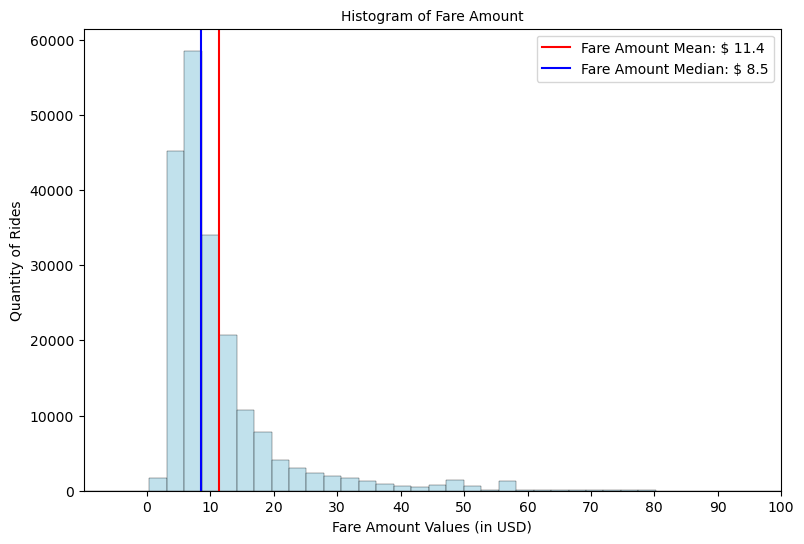

In [40]:
# histogram of fare_amount feature
mean_fare_amount = uber_df['fare_amount'].mean() # fare amount mean 
median_fare_amount = uber_df['fare_amount'].median() # fare amount median

fig, ax= plt.subplots(figsize = (9,6))

# plotting the histogram with the mean and median value of fare amount
sns.histplot(uber_df['fare_amount'], ax=ax, bins=200, color = 'lightblue', edgecolor='black')
ax.axvline(x=mean_fare_amount, color='red', label=f'Fare Amount Mean: $ {np.round(mean_fare_amount, 1)}')
ax.axvline(x=median_fare_amount, color='blue', label=f'Fare Amount Median: $ {np.round(median_fare_amount, 1)}')

# defining limits
ax.set_xlim(-10, 100)
tick_interval = 10
ax.set_xticks(range(0, 101, tick_interval))

# adding labels 
ax.legend()
ax.set_title("Histogram of Fare Amount", fontsize=10)
ax.set_xlabel("Fare Amount Values (in USD)")
ax.set_ylabel("Quantity of Rides")

As we see, the fare values are concentrated between ~$ \$5$ and ~$ \$20$. However, it is important to see if there are extremal values for this variable:

In [41]:
# showing the extremal values for fare amount feature 
uber_df.fare_amount.min(), uber_df.fare_amount.max()

(-52.0, 499.0)

Very interesting! We have both a very large fare amount value and negative fare amount value. Let us check these two situations. Checking the `fare_amount` of $\$ 499,00$:

In [42]:
# extremal positive value of fare amount
uber_df[uber_df['fare_amount']==499]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
170081,2011-04-10 04:10:00.00000064,499.0,2011-04-10 04:10:00 UTC,-73.968377,40.764602,-73.968368,40.7646,1


Of course this value is an outlier in our data. However, we need to understand if it is a correct value or not. Probably knowing the ride distance we can infer - based on other similar rides - what a reasonable fare amount should be for this ride. Let us look the negative values:

In [45]:
# checking the negative fare_amount
uber_df[uber_df['fare_amount']<0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
63395,2015-03-03 23:07:41.0000008,-5.00,2015-03-03 23:07:41 UTC,-73.992249,40.748936,-73.988518,40.748180,1
71246,2010-02-11 21:47:10.0000001,-3.30,2010-02-11 21:47:10 UTC,-73.952725,40.768235,-73.949928,40.772208,2
79903,2015-05-01 14:43:02.0000004,-3.50,2015-05-01 14:43:02 UTC,-73.982430,40.775024,-73.981750,40.778439,1
89322,2010-03-09 08:26:10.0000006,-49.57,2010-03-09 08:26:10 UTC,-73.972772,40.785657,-73.972867,40.785500,5
92063,2010-03-12 08:49:10.0000002,-23.70,2010-03-12 08:49:10 UTC,-73.952740,40.768233,-74.007028,40.707338,3
98875,2015-03-20 21:31:14.0000007,-52.00,2015-03-20 21:31:14 UTC,-74.000359,40.728729,-74.005699,40.728680,5
104080,2010-03-09 20:25:10.0000002,-7.30,2010-03-09 20:25:10 UTC,-73.952623,40.766942,-73.953787,40.784882,1
111589,2015-02-23 19:26:44.0000004,-52.00,2015-02-23 19:26:44 UTC,-73.984665,40.759026,0.000000,0.000000,5
139272,2010-02-23 18:52:10.0000003,-6.90,2010-02-23 18:52:10 UTC,-73.988727,40.736445,-73.977622,40.750487,1
148803,2010-02-12 10:50:10.0000005,-5.70,2010-02-12 10:50:10 UTC,-73.977300,40.742783,-73.988837,40.747465,3


It is interesting to see the presence of $17$ examples whose `fare_amount` is negative. I do not know exactly what it means but it can be a type of credit present on the app. 

Other interesting feature to explore outliers and strange values is `passenger_count` one. Let us to explore it.

In [46]:
# value counts for passsenger count feature
uber_df.passenger_count.value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

It is evident that $208$ passengers is an outlier in our data. Let's see this example:

In [15]:
uber_df[uber_df["passenger_count"]==208]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,2010-12-28 08:20:00.0000001,11.7,2010-12-28 08:20:00 UTC,-73.937795,40.758498,-73.937835,40.758415,208


As this is a unique example and nothing can be said about `passenger_count` in this case, we will drop this example later. Maybe $0$ passengers can be a strange value but in apps like uber it is possible to transport objects instead people - I do not know if it is the case, then I will maintain these data.

There are some important modifications to be done into our data. The features `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude` represent geographical coordinates. We can create a distance feature from them, representing the real distance of the ride. To do that, we can use Heaversine Distance, for example. Another modification to be done is regarding `pickup_datetime` feature. We can separate the date from the time and create two features. We will make these feature engineering later.